In [76]:
import os
import re
import glob
import pandas as pd
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import pyslha
import xml.etree.ElementTree as ET
import pyslha
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="white", context="paper", font_scale=1.8, 
        rc={"text.usetex": True, 
            'font.family':'Times New Roman', 
            'font.serif':'Times New Roman', 
            "savefig.dpi": 300})
#plt.rcParams['text.usetex'] = True
# Configure the plot aesthetics and labels
def configure_axes(ax, info=None):  
    if info is not None:
        multiline_info = "\n".join(info)
        ax.text(0.2, 0.5, multiline_info, transform=ax.transAxes, fontsize=16,
                color='black', bbox=dict(facecolor='silver', alpha=0.5,
                                         edgecolor='silver', boxstyle='round,pad=0.8',
                                         linewidth=0.2))
    def set_x_label(label, size=18, labelpad=5):
        ax.set_xlabel(label, size=size, labelpad=labelpad, loc="right", fontname='serif')
    def set_y_label(label, size=18, labelpad=5):
        ax.set_ylabel(label, size=size, labelpad=labelpad, loc="top", fontname='serif')
    def set_legend(framealpha=0.5, fontsize='16'):
        ax.legend(framealpha=framealpha, loc='best', fontsize=fontsize)
    ax.set_x_label = set_x_label
    ax.set_y_label = set_y_label
    ax.minorticks_on()
    ax.tick_params(direction='in', length=10, width=1.1, colors='black', which='major', top=True, right=True)
    ax.tick_params(direction='in', length=5, width=0.6, colors='black', which='minor', top=True, right=True)
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    for spine in ['left', 'right', 'top', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    sns.despine(left=False, bottom=False, right=False, top=False, offset=None, trim=False)
    ax.tick_params(axis='x', labelcolor='black', labelsize=16)
    ax.tick_params(axis='y', labelcolor='black', labelsize=16)

cm = plt.colormaps['RdYlBu']


In [77]:
# SAF and CLs file patterns
saf_patterns = [
    '/home/yoxara/Eff_MA5_LO/_run_*/Output/SAF/*/*.saf'
]
cls_patterns = [
    '/home/yoxara/Eff_MA5_LO/_run_*/Output/SAF/*/CLs_output.dat'
]

saf_files = sorted([file for pattern in saf_patterns for file in glob.glob(pattern)])
cls_files = sorted([file for pattern in cls_patterns for file in glob.glob(pattern)])
inputListPattern = sorted(glob.glob('/home/yoxara/Eff_MA5_LO/_run_*/Input/*.list'))

if len(inputListPattern) != len(cls_files):
    print(f"Warning: Mismatch in input files ({len(inputListPattern)}) and CLs files ({len(cls_files)})!")

sample_global_info_pattern = re.compile(r"<SampleGlobalInfo>(.*?)</SampleGlobalInfo>", re.DOTALL)

saf_to_theoretical = {}
final_results = []
allDataDicts = []


# Process SAF and CLs files in pairs
for inputFile, cls_file, saf_file in zip(inputListPattern, cls_files, saf_files):
    try:
        # Read the HepMC file location from the input file
        with open(inputFile, 'r') as f:
            hepMCfile = f.read().strip()
        
        hepDir = os.path.dirname(hepMCfile)
        banner_candidates = glob.glob(f"{hepDir}/**/*banner.txt", recursive=True)
        
        if not banner_candidates:
            print(f"No banner file found for input file: {inputFile}")
            continue
        
        # Use the most recently modified banner file
        banner_file = max(banner_candidates, key=os.path.getmtime)

        # SLHA information from the banner file
        xtree = ET.parse(banner_file)
        xroot = xtree.getroot()
        slha = xroot.find('header').find('slha').text
        pars = pyslha.readSLHA(slha)
        mMed = pars.blocks['MASS'].get(55)  # Stop mass
        mchi = pars.blocks['MASS'].get(52)  # Neutralino mass

        if mMed is None or mchi is None:
            print(f"Masses not found in SLHA block for {inputFile}")
            continue

        allDataDicts.append({
            "Input File": inputFile,
            "CLs File": cls_file,
            "SAF File": saf_file,
            "HepMC Dir": hepDir,
            "Banner File": banner_file,
            "mMed (GeV)": mMed,
            "mchi (GeV)": mchi
        })

        # theoretical cross-section from the SAF file
        sigma_theoretical = None
        with open(saf_file, 'r') as file:
            content = file.read()
            match = sample_global_info_pattern.search(content)
            if match:
                block_content = match.group(1).strip()
                for line in block_content.splitlines():
                    line = line.strip()
                    if line and not line.startswith("#"):
                        try:
                            sigma_theoretical = float(line.split()[0])
                            saf_to_theoretical[os.path.basename(saf_file).replace('.saf', '')] = sigma_theoretical
                            break  
                        except ValueError:
                            pass
        if sigma_theoretical is None:
            print(f"Could not extract cross-section from SAF file: {saf_file}")
            continue

        # k-factor
        #NNLO_cross_section = interpolator(sigma_theoretical)
        #k_factor = NNLO_cross_section / sigma_theoretical

        # Process the CLs_output.dat file
        with open(cls_file.strip(), 'r') as f:
            lines_output = f.readlines()

        for line in lines_output:
            if not line.strip():  
                continue
            if not line.strip().startswith("#"): 
                if "||" not in line:
                    print(f"Skipping malformed line: {line.strip()}")
                    continue
                try:
                    main_part, efficiency_part = line.split("||")
                    main_parts = re.split(r'\s{2,}', main_part.strip())
                    efficiency_parts = re.split(r'\s+', efficiency_part.strip())

                    if len(main_parts) < 4 or len(efficiency_parts) < 2:
                        print(f"Incomplete line detected: {line.strip()}")
                        continue

                    sr = main_parts[1]  # Signal region
                    sigma_exp = float(main_parts[2])  # Sigma_95_exp
                    sigma_obs = float(main_parts[3])  # Sigma_95_obs
                    efficiency = float(efficiency_parts[0])  # Efficiency
                    stat = float(efficiency_parts[1])  # Statistical uncertainty

                    # Calculate Signal Strength Obs and Signal Strength Exp
                    #Signal Strength Obs = k_factor * sigma_theoretical / sigma_obs
                    #Signal Strength Exp = k_factor * sigma_theoretical / sigma_exp

                    #status_obs = "Included" if Signal Strength Obs < 1 else "Excluded"
                    #status_exp = "Included" if Signal Strength Exp < 1 else "Excluded"

                    #final_results.append((sr, sigma_exp, sigma_obs, efficiency, stat,
                    #                      sigma_theoretical, k_factor, Signal Strength Obs, Signal Strength Exp,
                    #                      status_obs, status_exp, os.path.basename(saf_file).replace('.saf', ''),
                    #                      mMed, mchi))
                    final_results.append((sr, sigma_exp, sigma_obs, efficiency, stat,
                                          sigma_theoretical, os.path.basename(saf_file).replace('.saf', ''),
                                          mMed, mchi))
                except (ValueError, IndexError) as e:
                    print(f"Error processing line: {line.strip()}\n{e}")

    except FileNotFoundError as e:
        print(f"File not found error for {inputFile}: {e}")
    except ET.ParseError as e:
        print(f"Error parsing XML in {banner_file}: {e}")
    except Exception as e:
        print(f"Unexpected error processing {inputFile}: {e}")

df_data = pd.DataFrame(allDataDicts)
df_final_results = pd.DataFrame(
    final_results,
#    columns=["Signal Region", "Sigma_95_exp (pb)", "Sigma_95_obs (pb)", "Efficiency", "Stat",
#             "Sigma_theoretical (pb)", "k_factor", "Signal Strength Obs", "Signal Strength Exp",
#             "Status Obs", "Status Exp", "SAF File", "mMed (GeV)", "mchi (GeV)"])
     columns=["Signal Region", "Sigma_95_exp (pb)", "Sigma_95_obs (pb)", "Efficiency", "Stat",
             "Sigma_theoretical (pb)", "SAF File", "mMed (GeV)", "mchi (GeV)"])
df_final_results


,Signal Region,Sigma_95_exp (pb),Sigma_95_obs (pb),Efficiency,Stat,Sigma_theoretical (pb),SAF File,mMed (GeV),mchi (GeV)
0,IM0,3253.209909,4133.211410,0.000174,0.000000,192847.500000,spin1_run_01_vector_50_1,50.0,1.0
1,IM1,1737.930548,2185.194218,0.000130,0.000000,192847.500000,spin1_run_01_vector_50_1,50.0,1.0
2,IM2,1304.322343,1790.865564,0.000087,0.000000,192847.500000,spin1_run_01_vector_50_1,50.0,1.0
3,IM3,-1.000000,-1.000000,0.000000,0.000000,192847.500000,spin1_run_01_vector_50_1,50.0,1.0
4,IM4,-1.000000,-1.000000,0.000000,0.000000,192847.500000,spin1_run_01_vector_50_1,50.0,1.0
...,...,...,...,...,...,...,...,...,...
10655,EM8,1.649891,1.897992,0.000490,0.000005,6.075731,spin1_run_99_vector_1000_450,1000.0,450.0
10656,EM9,8.970868,7.649272,0.000054,0.000002,6.075731,spin1_run_99_vector_1000_450,1000.0,450.0
10657,EM10,1.912715,4.086456,0.000163,0.000003,6.075731,spin1_run_99_vector_1000_450,1000.0,450.0
10658,EM11,-1.000000,-1.000000,0.000000,0.000000,6.075731,spin1_run_99_vector_1000_450,1000.0,450.0


In [78]:
k_factor = 1.0
df_final_results['Signal Strength Obs'] =  (k_factor*df_final_results['Sigma_theoretical (pb)'] ) / df_final_results['Sigma_95_obs (pb)']
df_final_results['Signal Strength Exp'] =   (k_factor*df_final_results['Sigma_theoretical (pb)']) / df_final_results['Sigma_95_exp (pb)']
df_final_results['Status Obs'] = df_final_results['Signal Strength Obs'].apply(lambda x: 'Included' if x > 1 else 'Excluded')
df_final_results['Status Exp'] = df_final_results['Signal Strength Exp'].apply(lambda x: 'Included' if x > 1 else 'Excluded')
df_final_results


,Signal Region,Sigma_95_exp (pb),Sigma_95_obs (pb),Efficiency,Stat,Sigma_theoretical (pb),SAF File,mMed (GeV),mchi (GeV),Signal Strength Obs,Signal Strength Exp,Status Obs,Status Exp
0,IM0,3253.209909,4133.211410,0.000174,0.000000,192847.500000,spin1_run_01_vector_50_1,50.0,1.0,46.658030,59.279144,Included,Included
1,IM1,1737.930548,2185.194218,0.000130,0.000000,192847.500000,spin1_run_01_vector_50_1,50.0,1.0,88.251881,110.963870,Included,Included
2,IM2,1304.322343,1790.865564,0.000087,0.000000,192847.500000,spin1_run_01_vector_50_1,50.0,1.0,107.683962,147.852639,Included,Included
3,IM3,-1.000000,-1.000000,0.000000,0.000000,192847.500000,spin1_run_01_vector_50_1,50.0,1.0,-192847.500000,-192847.500000,Excluded,Excluded
4,IM4,-1.000000,-1.000000,0.000000,0.000000,192847.500000,spin1_run_01_vector_50_1,50.0,1.0,-192847.500000,-192847.500000,Excluded,Excluded
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10655,EM8,1.649891,1.897992,0.000490,0.000005,6.075731,spin1_run_99_vector_1000_450,1000.0,450.0,3.201136,3.682505,Included,Included
10656,EM9,8.970868,7.649272,0.000054,0.000002,6.075731,spin1_run_99_vector_1000_450,1000.0,450.0,0.794289,0.677273,Excluded,Excluded
10657,EM10,1.912715,4.086456,0.000163,0.000003,6.075731,spin1_run_99_vector_1000_450,1000.0,450.0,1.486797,3.176496,Included,Included
10658,EM11,-1.000000,-1.000000,0.000000,0.000000,6.075731,spin1_run_99_vector_1000_450,1000.0,450.0,-6.075731,-6.075731,Excluded,Excluded


In [79]:
#df_final_results.to_csv("/home/yoxara/workstation/MonoXSMS/data/DF_UL_Spin1_new.csv", index=False)
display(df_final_results.head(4))


,Signal Region,Sigma_95_exp (pb),Sigma_95_obs (pb),Efficiency,Stat,Sigma_theoretical (pb),SAF File,mMed (GeV),mchi (GeV),Signal Strength Obs,Signal Strength Exp,Status Obs,Status Exp
0,IM0,3253.209909,4133.211410,0.000174,0.0,192847.5,spin1_run_01_vector_50_1,50.0,1.0,46.658030,59.279144,Included,Included
1,IM1,1737.930548,2185.194218,0.000130,0.0,192847.5,spin1_run_01_vector_50_1,50.0,1.0,88.251881,110.963870,Included,Included
2,IM2,1304.322343,1790.865564,0.000087,0.0,192847.5,spin1_run_01_vector_50_1,50.0,1.0,107.683962,147.852639,Included,Included
3,IM3,-1.000000,-1.000000,0.000000,0.0,192847.5,spin1_run_01_vector_50_1,50.0,1.0,-192847.500000,-192847.500000,Excluded,Excluded


In [80]:
#df_final_results = pd.read_csv("/home/yoxara/workstation/MonoXSMS/data/DF_UL_Spin1.csv")


In [81]:
max_sigma_exp_per_saf = df_final_results.loc[
    df_final_results.groupby("SAF File")["Signal Strength Exp"].idxmax()   #r_exp max
]

max_sigma_exp_per_saf


,Signal Region,Sigma_95_exp (pb),Sigma_95_obs (pb),Efficiency,Stat,Sigma_theoretical (pb),SAF File,mMed (GeV),mchi (GeV),Signal Strength Obs,Signal Strength Exp,Status Obs,Status Exp
15,EM2,576.213304,569.892594,0.000087,0.000000e+00,192847.500000,spin1_run_01_vector_50_1,50.0,1.0,338.392711,334.680748,Included,Included
43,EM4,182.662154,256.554044,0.000096,0.000000e+00,27033.760000,spin1_run_02_vector_100_1,100.0,1.0,105.372574,147.998693,Included,Included
66,EM1,443.703388,434.910154,0.000287,1.000000e-07,27083.140000,spin1_run_03_vector_100_10,100.0,10.0,62.272954,61.038840,Included,Included
95,EM4,68.903329,96.617440,0.000255,1.000000e-07,8007.648000,spin1_run_04_vector_150_1,150.0,1.0,82.879944,116.215691,Included,Included
124,EM7,27.523711,40.178529,0.000052,1.000000e-07,2096.746000,spin1_run_05_vector_150_75,150.0,75.0,52.185734,76.179625,Included,Included
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10550,EM7,1.113622,1.619338,0.001292,6.400000e-06,8.817854,spin1_run_95_vector_1000_250,1000.0,250.0,5.445346,7.918177,Included,Included
10578,EM9,1.509701,1.295333,0.000322,3.300000e-06,8.634134,spin1_run_96_vector_1000_300,1000.0,300.0,6.665570,5.719104,Included,Included
10603,EM8,1.068567,1.224367,0.000759,5.200000e-06,8.126068,spin1_run_97_vector_1000_350,1000.0,350.0,6.636954,7.604642,Included,Included
10631,EM10,0.716702,1.530912,0.000436,4.100000e-06,7.446351,spin1_run_98_vector_1000_400,1000.0,400.0,4.863998,10.389739,Included,Included


# ATLAS Contour

In [82]:
DataDF_Obs_DMA= pd.read_csv('../../data/HEPData-ins1847779-v1-csv/ContourobsDMA.csv', skiprows=7)
DataDF_Exp_DMA = pd.read_csv('../../data/HEPData-ins1847779-v1-csv/ContourexpDMA.csv', skiprows=7)
Data_Obs_DMA_m1 = pd.read_csv('../../data/HEPData-ins1847779-v1-csv/Contourobs_m1DMA.csv', skiprows=7)
Data_Obs_DMA_p1 = pd.read_csv('../../data/HEPData-ins1847779-v1-csv/Contourobs_p1DMA.csv', skiprows=7)
DataDF_Exp_DMA_m1 = pd.read_csv('../../data/HEPData-ins1847779-v1-csv/Contourexp_m1DMA.csv', skiprows=7)
DataDF_Exp_DMA_p1 = pd.read_csv('../../data/HEPData-ins1847779-v1-csv/Contourexp_p1DMA.csv', skiprows=7)
DataDF_Exp_DMA_m2 = pd.read_csv('../../data/HEPData-ins1847779-v1-csv/Contourexp_m2DMA.csv', skiprows=7)
DataDF_Exp_DMA_p2 = pd.read_csv('../../data/HEPData-ins1847779-v1-csv/Contourexp_p2DMA.csv', skiprows=7)
MZp = DataDF_Obs_DMA.iloc[:, 0].values
MChi = DataDF_Obs_DMA.iloc[:, 1].values
#MZp
#MChi
#DataDF_Obs_DMA
#specific_row = DataDF_Obs_DMA.loc[DataDF_Obs_DMA['$m_{Z_{A}}$ [GeV]'] == 1000.1] %400.39,

#specific_row2 = Data_Obs_DMA_m1.loc[Data_Obs_DMA['$m_{\chi}$ [GeV]'] == 200]
#specific_row2
#DataDF_Exp_DMA


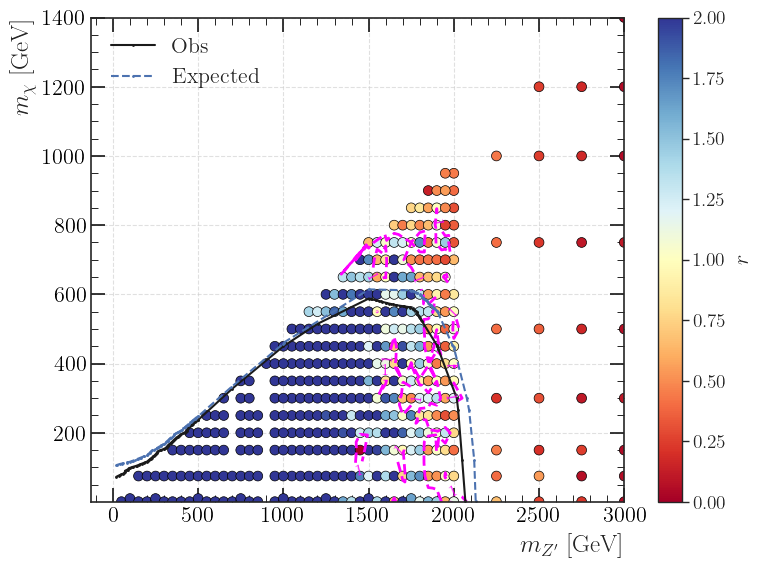

In [83]:
# signal_strength_obs
fig, ax = plt.subplots(figsize=(8,6))
configure_axes(ax)

scatter = ax.scatter(
    max_sigma_exp_per_saf["mMed (GeV)"],
    max_sigma_exp_per_saf["mchi (GeV)"],
    c=max_sigma_exp_per_saf["Signal Strength Obs"],
    cmap=cm,
    s=50,
    edgecolor="black",
    linewidth=0.5,
    marker='o',
    vmin=0,
    vmax=2
)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("$r$", fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Contour for r ~ 1
x = max_sigma_exp_per_saf["mMed (GeV)"]
y = max_sigma_exp_per_saf["mchi (GeV)"]
z = max_sigma_exp_per_saf["Signal Strength Obs"]

xi, yi = np.meshgrid(
    np.linspace(x.min(), x.max(), 200),
    np.linspace(y.min(), y.max(), 200)
)
zi = griddata((x, y), z, (xi, yi), method='linear')

#contour = ax.contour(xi, yi, zi, levels=[1], colors="magenta", linestyles="--", linewidths=1.5)
contour = ax.tricontour(x, y, z, levels=[1], colors="magenta", linestyles="--", linewidths=2)
ax.clabel(contour, inline=True, fontsize=12) #fmt="r = 1",
ax.plot(DataDF_Obs_DMA.iloc[:, 0], DataDF_Obs_DMA.iloc[:, 1], label='Obs', color='k', marker='o', linestyle='-', linewidth=1.5, markersize=1)
ax.plot(DataDF_Exp_DMA.iloc[:, 0], DataDF_Exp_DMA.iloc[:, 1], label='Expected', color='b', marker='o', linestyle='--', linewidth=1.5, markersize=1)

ax.set_x_label(r'$m_{Z^{\prime}}$ [GeV]')
ax.set_y_label(r'$m_{\chi}$ [GeV]')
plt.grid(True, linestyle='--', alpha=0.6)
#plt.ylim(290, 1000)
#plt.xlim(300, 2500)
ax.legend(frameon=False, loc='best')
plt.tight_layout()
plt.show()


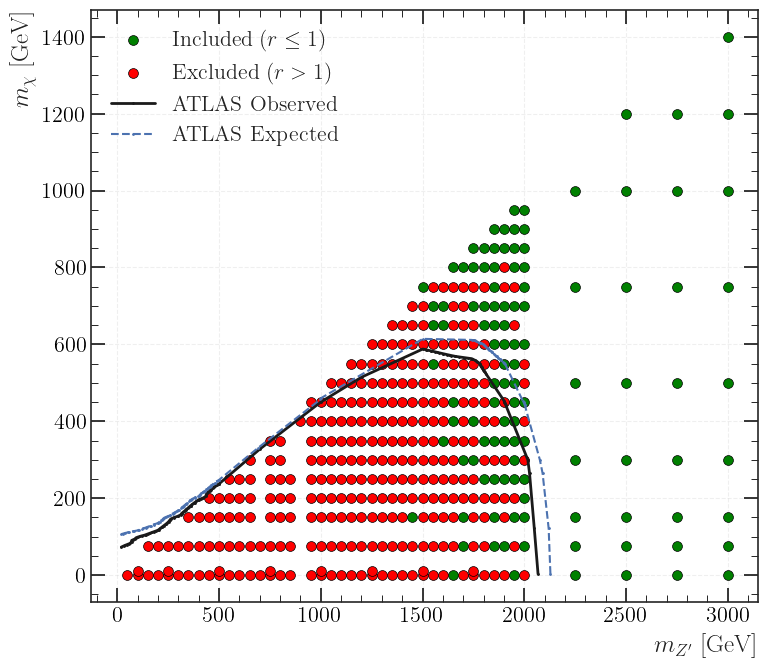

In [84]:
fig, ax = plt.subplots(figsize=(8, 7))
configure_axes(ax)
# Add green points for r <= 1 (r Obs <= 1)
green_points = max_sigma_exp_per_saf[max_sigma_exp_per_saf["Signal Strength Obs"] <= 1]
ax.scatter(
    green_points["mMed (GeV)"],
    green_points["mchi (GeV)"],
    c="green",
    label=r"Included ($r \leq 1$)",
    s=50,
    edgecolor="black",
    linewidth=0.5
)

# Add red points for r >  1 (r Obs > 1)
red_points = max_sigma_exp_per_saf[max_sigma_exp_per_saf["Signal Strength Obs"] > 1]
ax.scatter(
    red_points["mMed (GeV)"],
    red_points["mchi (GeV)"],
    c="red",
    label=r"Excluded ($r > 1$)",
    s=50,
    edgecolor="black",
    linewidth=0.5
)

# Contour for mu ~ 1
x = max_sigma_exp_per_saf["mMed (GeV)"]
y = max_sigma_exp_per_saf["mchi (GeV)"]
z = max_sigma_exp_per_saf["Signal Strength Obs"]
xi, yi = np.meshgrid(
    np.linspace(x.min(), x.max(), 200),
    np.linspace(y.min(), y.max(), 200)
)
zi = griddata((x, y), z, (xi, yi), method='linear')
#contour = ax.contour(xi, yi, zi, levels=[1], colors="magenta", linestyles="--", linewidths=2)
#ax.clabel(contour, fmt="r = 1", inline=True, fontsize=12)
#ax.plot(hep_data_ttbnffObs['mMed [GeV]'], hep_data_ttbnffObs['mchi [GeV]'], color="black", label='ATLAS Observation', linewidth=1)
ax.plot(DataDF_Obs_DMA.iloc[:, 0], DataDF_Obs_DMA.iloc[:, 1], label=r'ATLAS Observed', color='k', marker='o', linestyle='-', linewidth=2, markersize=1)
ax.plot(DataDF_Exp_DMA.iloc[:, 0], DataDF_Exp_DMA.iloc[:, 1], label=r'ATLAS Expected', color='b', marker='o', linestyle='--', linewidth=1.5, markersize=1)
ax.set_x_label(r'$m_{Z^{\prime}}$ [GeV]')
ax.set_y_label(r'$m_{\chi}$ [GeV]')
ax.legend()
plt.grid(True, linestyle='--', alpha=0.6)
#plt.ylim(10, 900)
#plt.xlim(10, 2500)
ax.legend(framealpha=0.0, loc='best')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
